In [20]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import netCDF4 as nc
import matplotlib.cm as cm
#from mpl_toolkits.basemap import Basemap

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 7]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sys.path.append('/home/hpc-rosneft/drigo/surrogate/src/')
from dataset import load_features, load, load_variable_years
from tqdm import tqdm_notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_arr = np.load('/home/hpc-rosneft/drigo/surrogate/data/out3.npy')
global lons, lats
lons = nc.Dataset('/home/hpc-rosneft/nfs/0_42/share_rosneft/output_yearly/2010/T_grid_y2010.nc').variables['nav_lon'][:]
lats = nc.Dataset('/home/hpc-rosneft/nfs/0_42/share_rosneft/output_yearly/2010/T_grid_y2010.nc').variables['nav_lat'][:]
ref = load_variable_years('thick_cr2smos', [2014, 2015])
mask=nc.Dataset('/home/hpc-rosneft/drigo/surrogate/data/land-exapmle-int.nc').variables['Conc'][:].mask[0,:,:]
data_mean = load_variable_years('thick_cr2smos', list(range(2010, 2016)))

In [3]:
mean2d = np.nanmean(data_mean, axis=0)
#mean = np.concatenate([[mean2d]] * np.shape(ref)[0], axis=0)

mse_data_ref = []
mse_mean_ref = []

mean_data = []
mean_ref = []
ref[np.isnan(ref)] = 0

/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [4]:
def interp(data, target):
    from scipy import interpolate
    x = np.arange(0, target.shape[1])
    y = np.arange(0, target.shape[0])
    xx, yy = np.meshgrid(x, y)
    #mask invalid values
    data = np.ma.masked_invalid(data)
    
    #get only the valid values
    x1 = xx[~data.mask]
    y1 = yy[~data.mask]
    newarr = data[~data.mask]
    GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                               (xx, yy),
                               method='nearest')
    return GD1

In [7]:
def plot(pred,ref):
    cmap=plt.get_cmap('rainbow')
    cmap.set_bad('white')
    plt.subplot(1, 2, 1)
    plt.title('Prediction')
    plt.imshow(pred, cmap=cmap)

    plt.subplot(1, 2, 2)
    plt.title('Sattelite')
    plt.imshow(ref, cmap=cmap)
    plt.show()
    
def mse(pred, ref):
    mse = np.nanmean((ref_field - ndata)**2)
    return mse

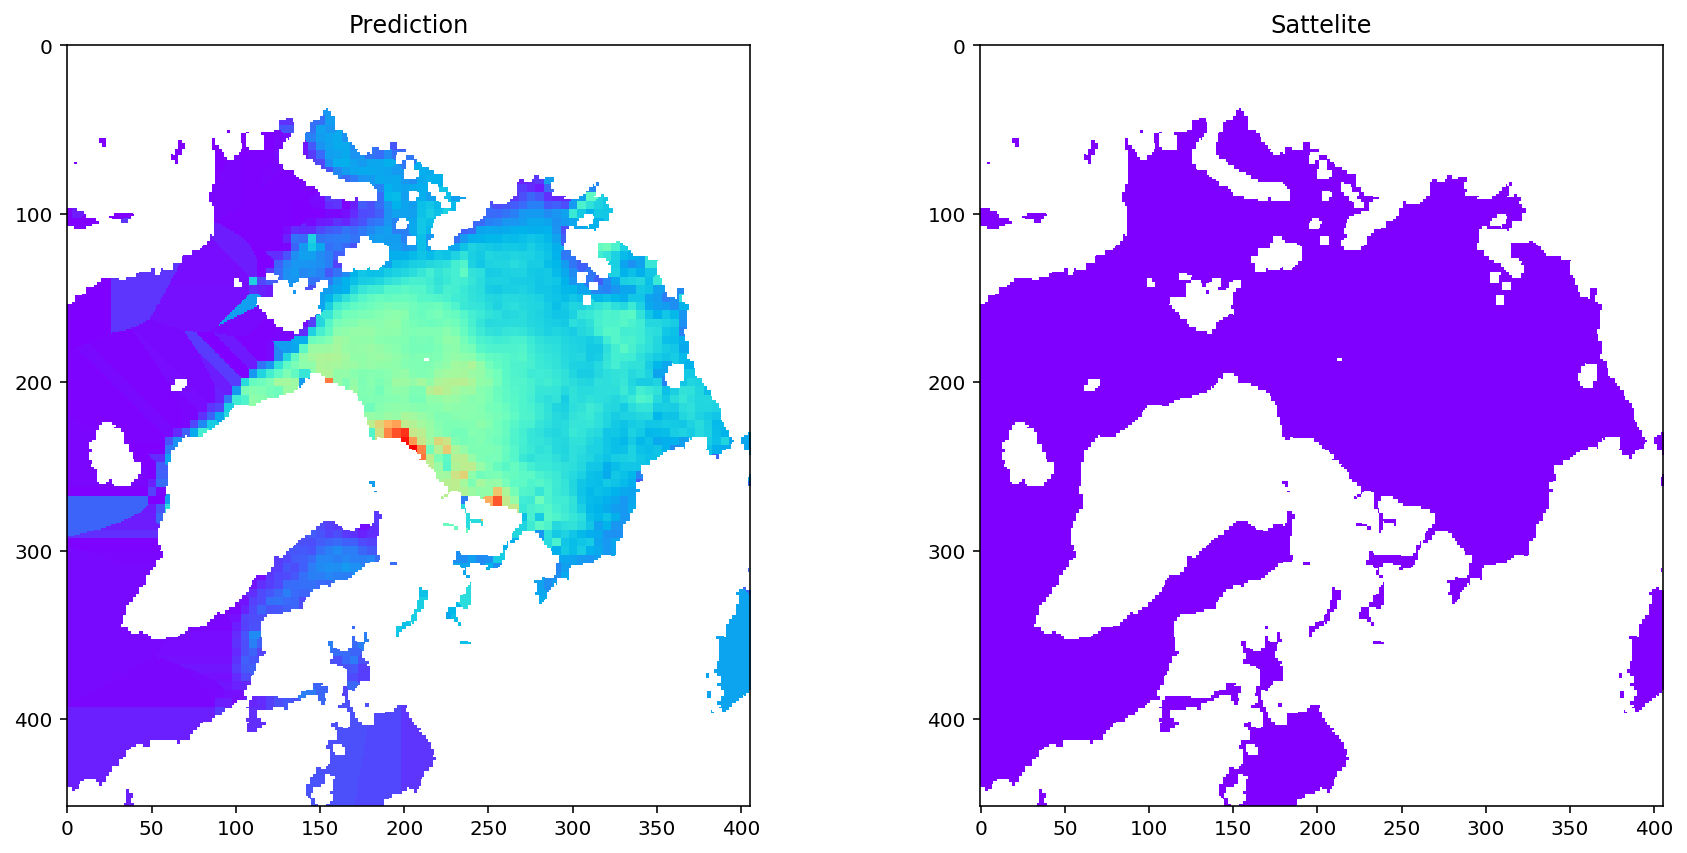

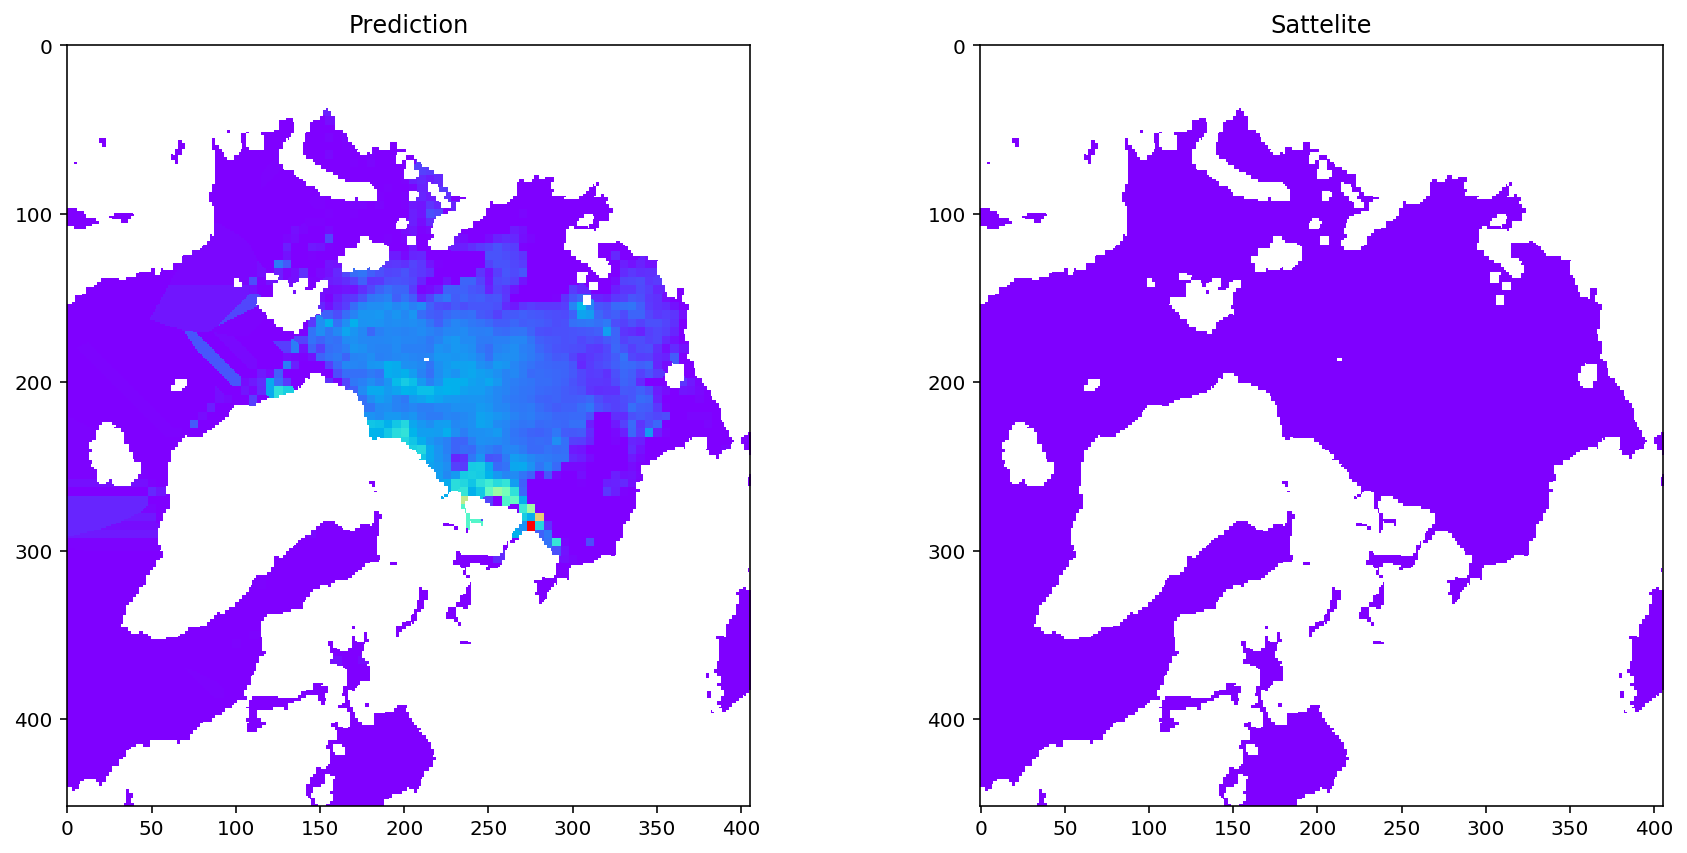

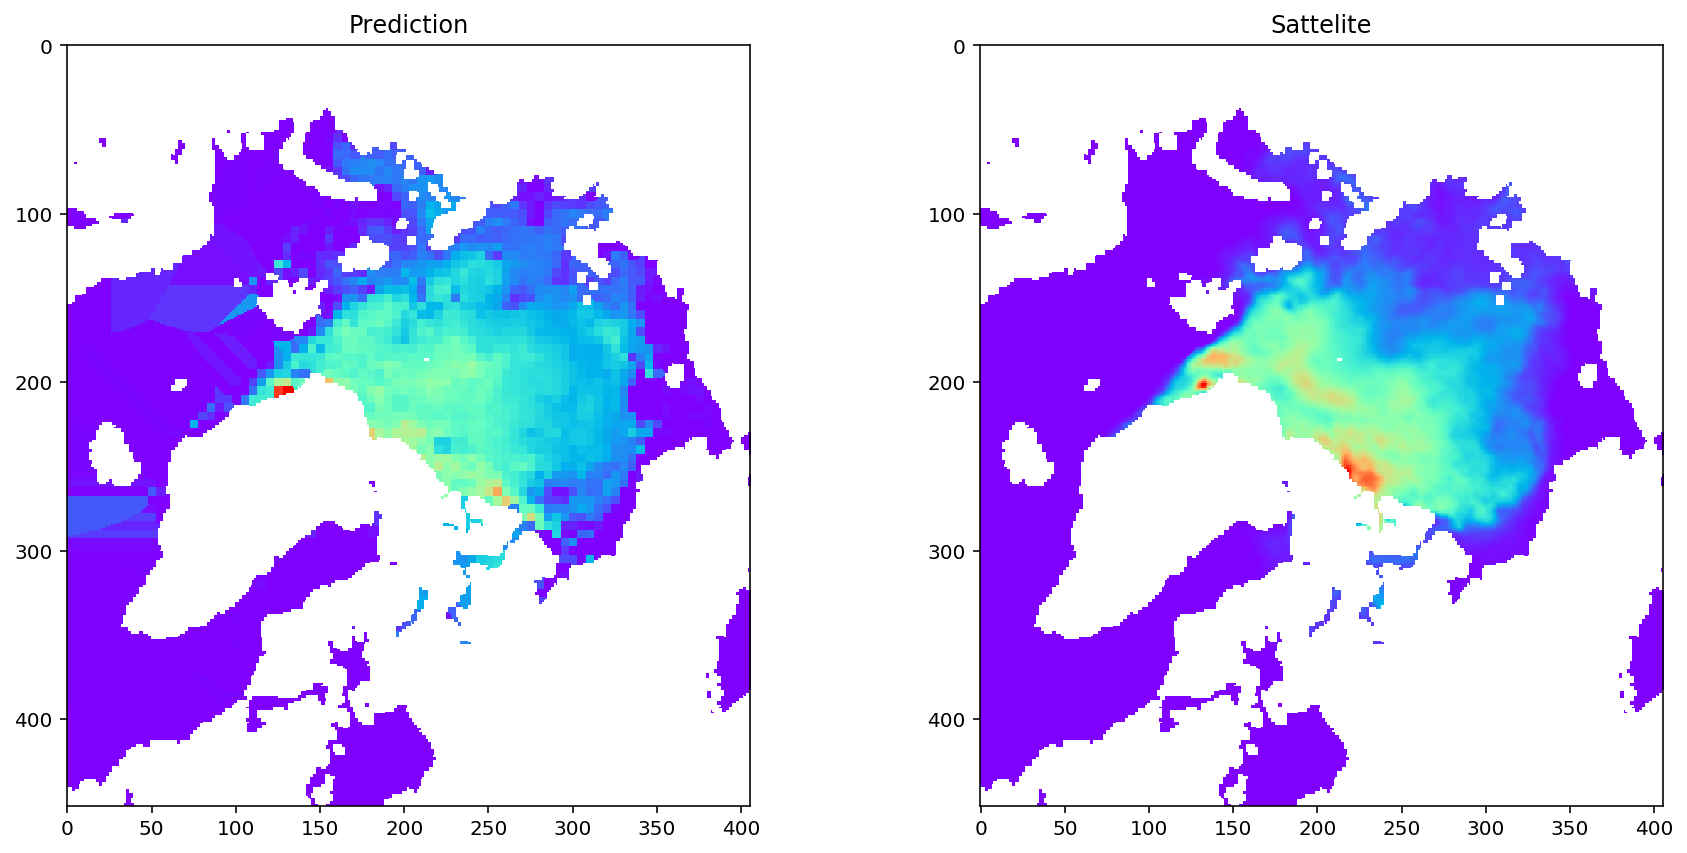

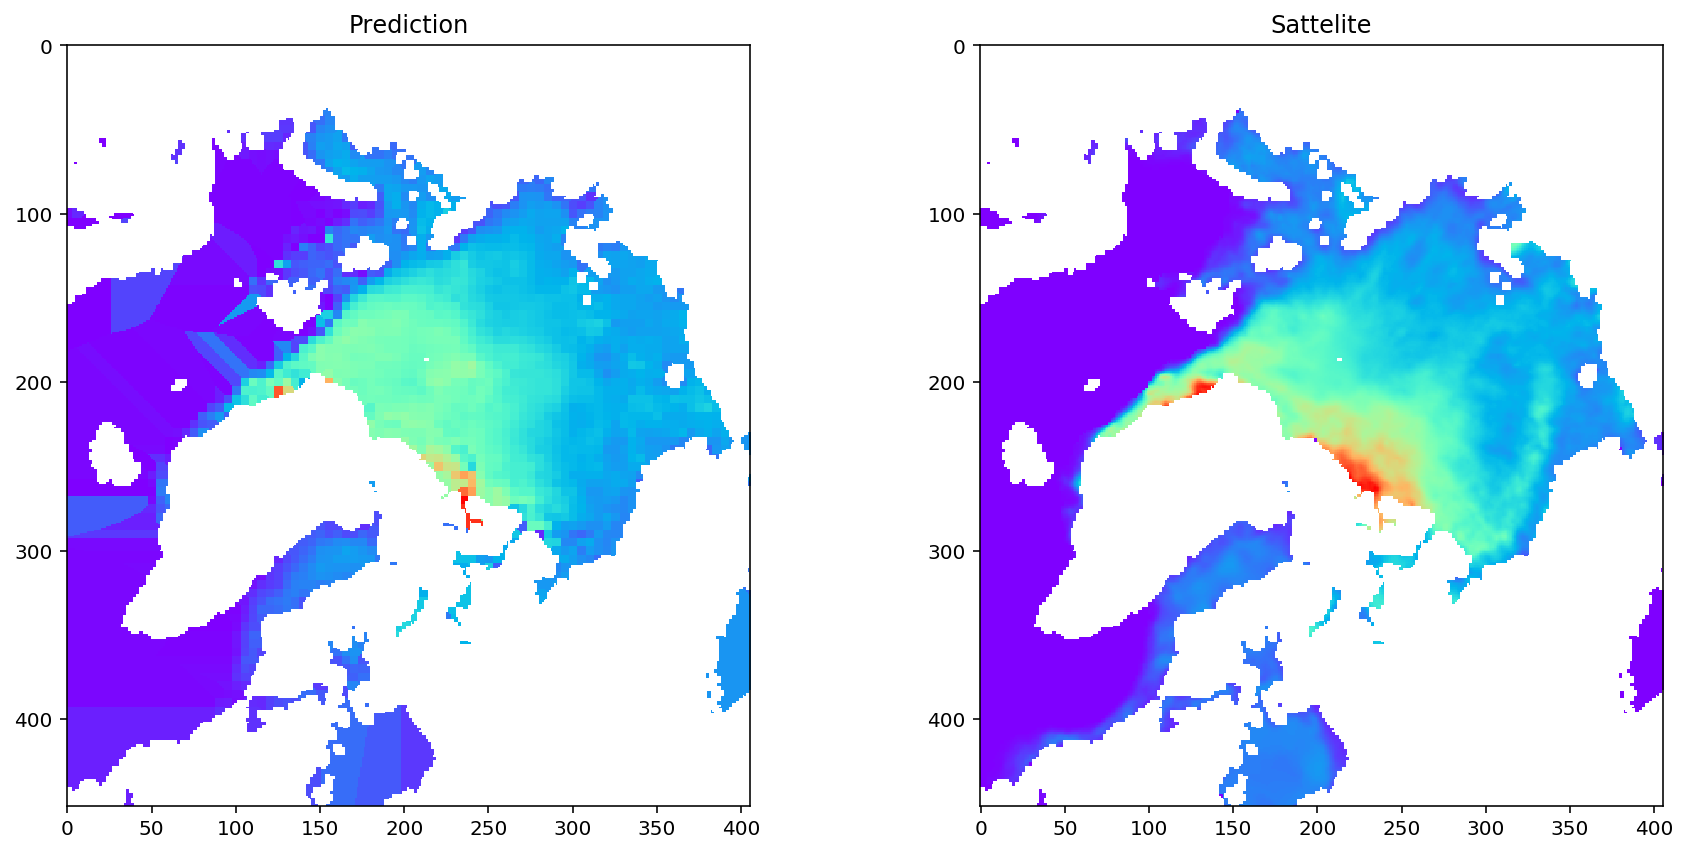

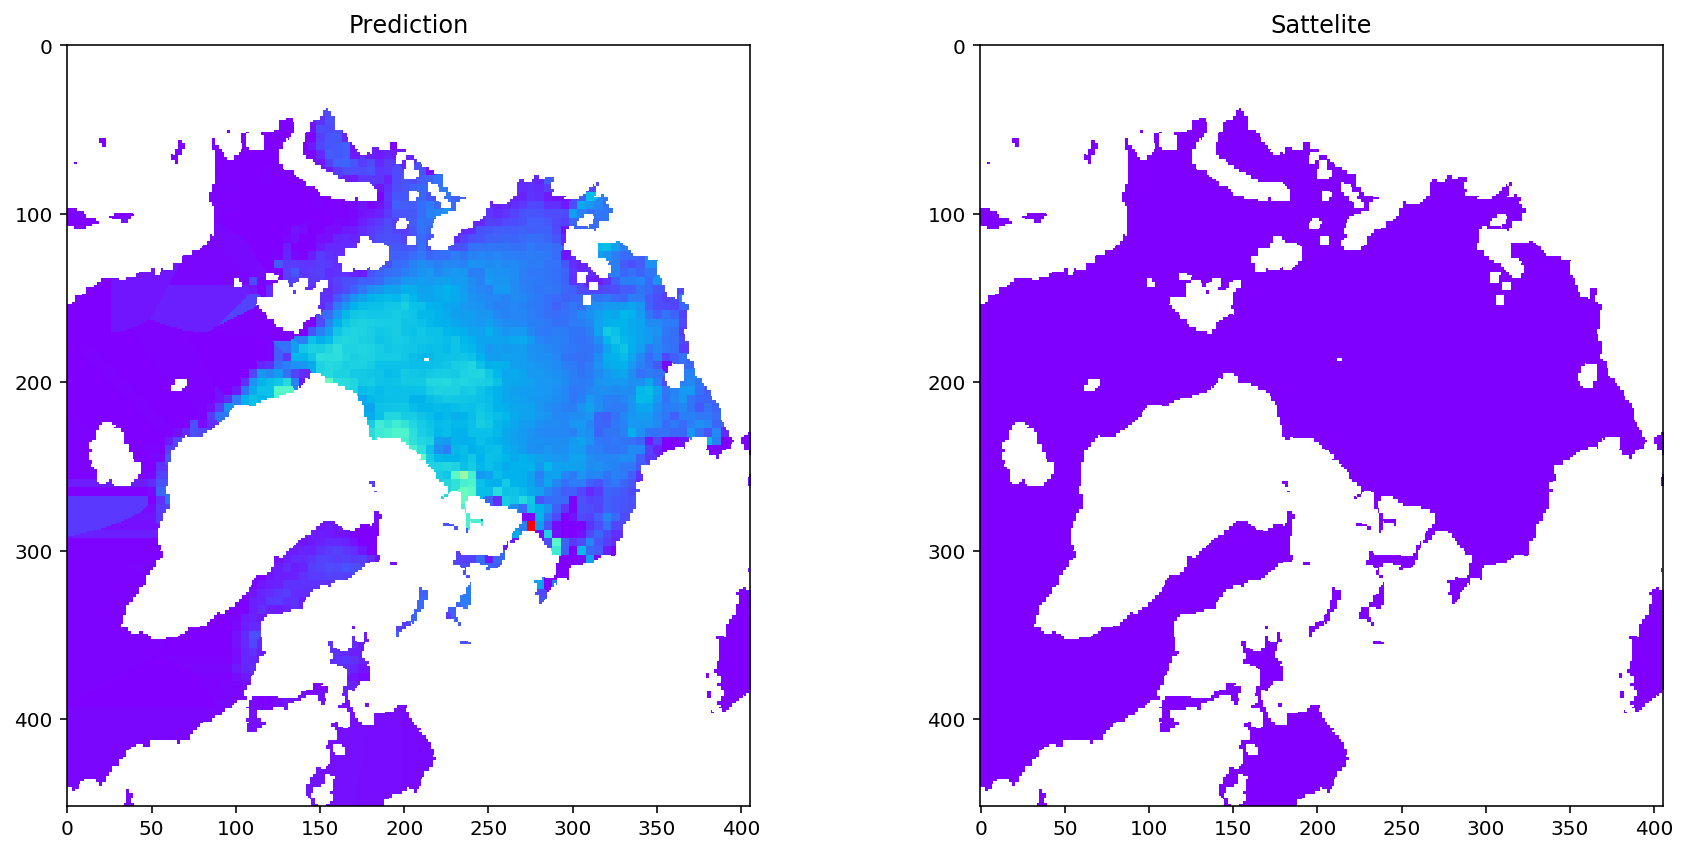

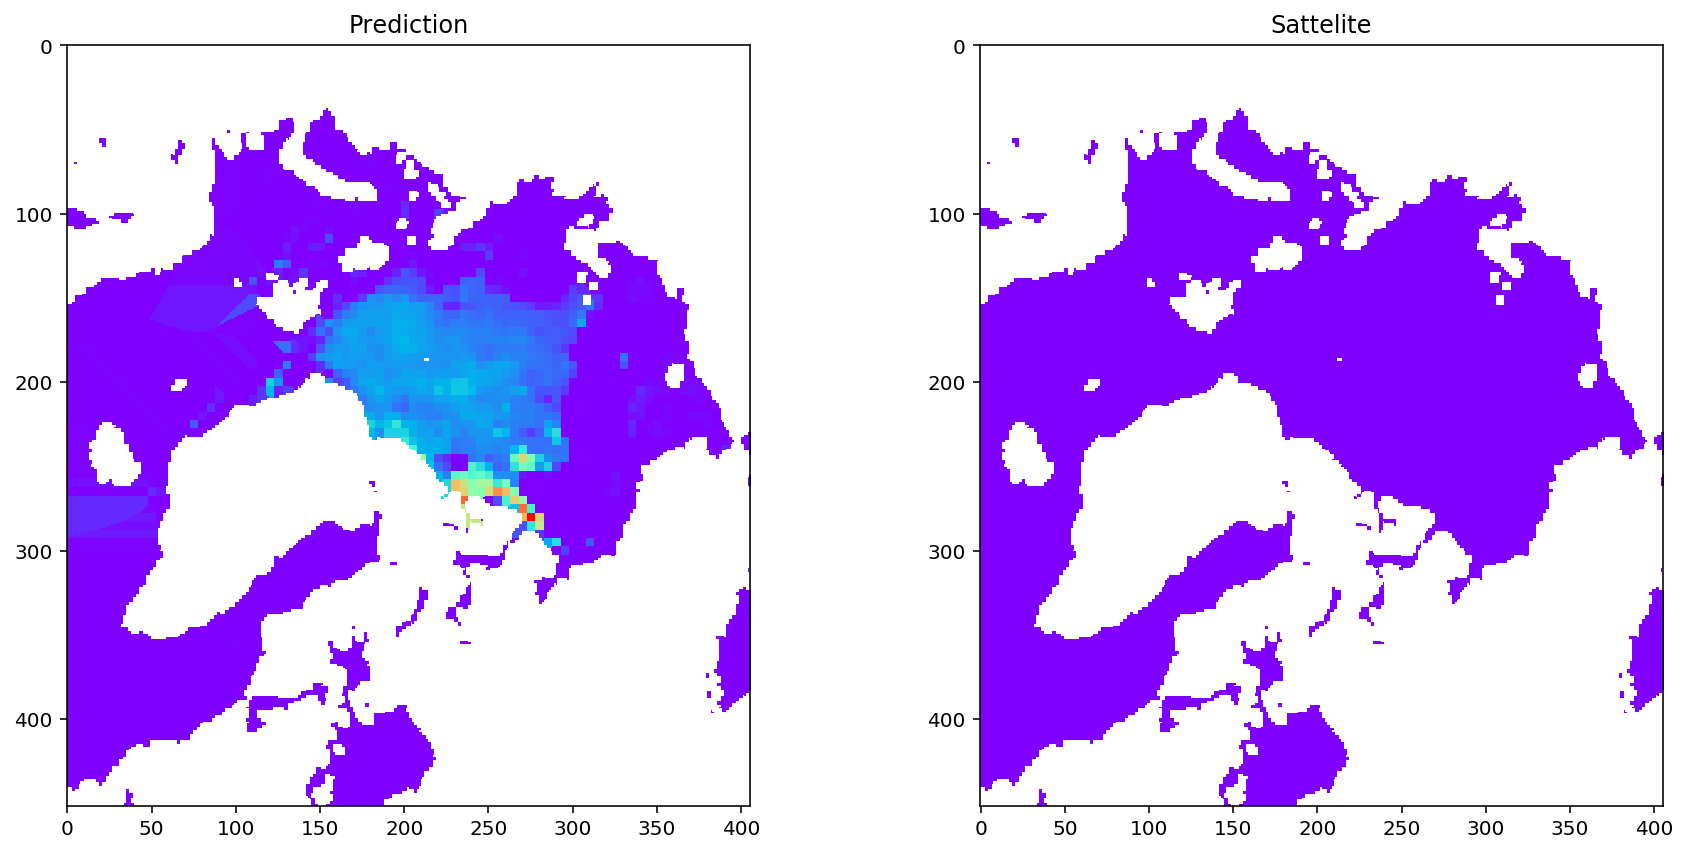

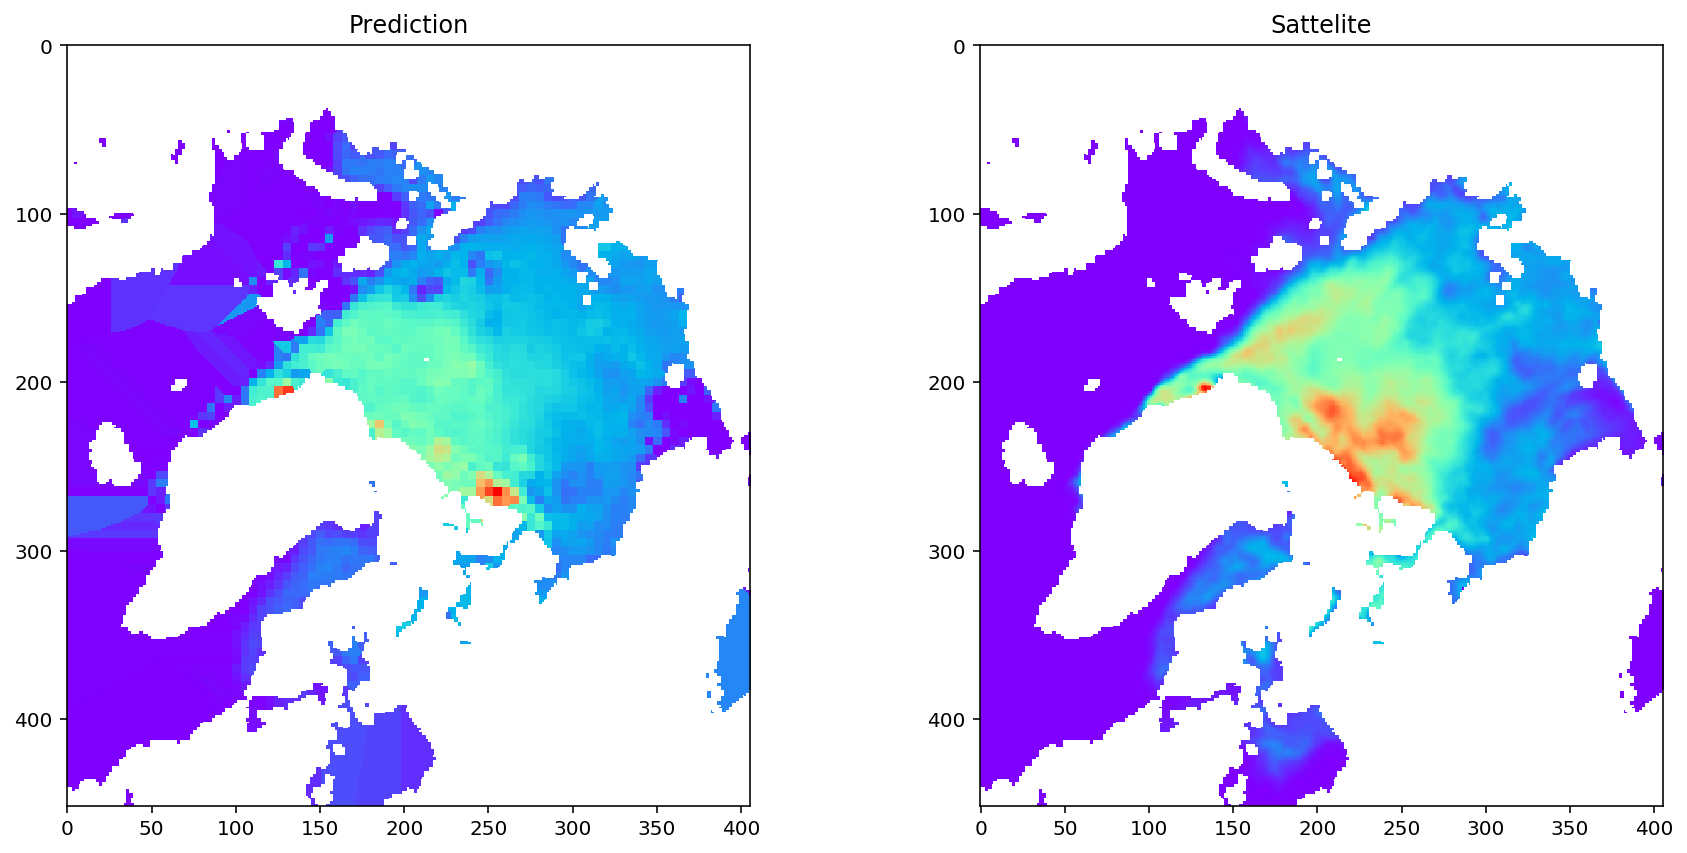

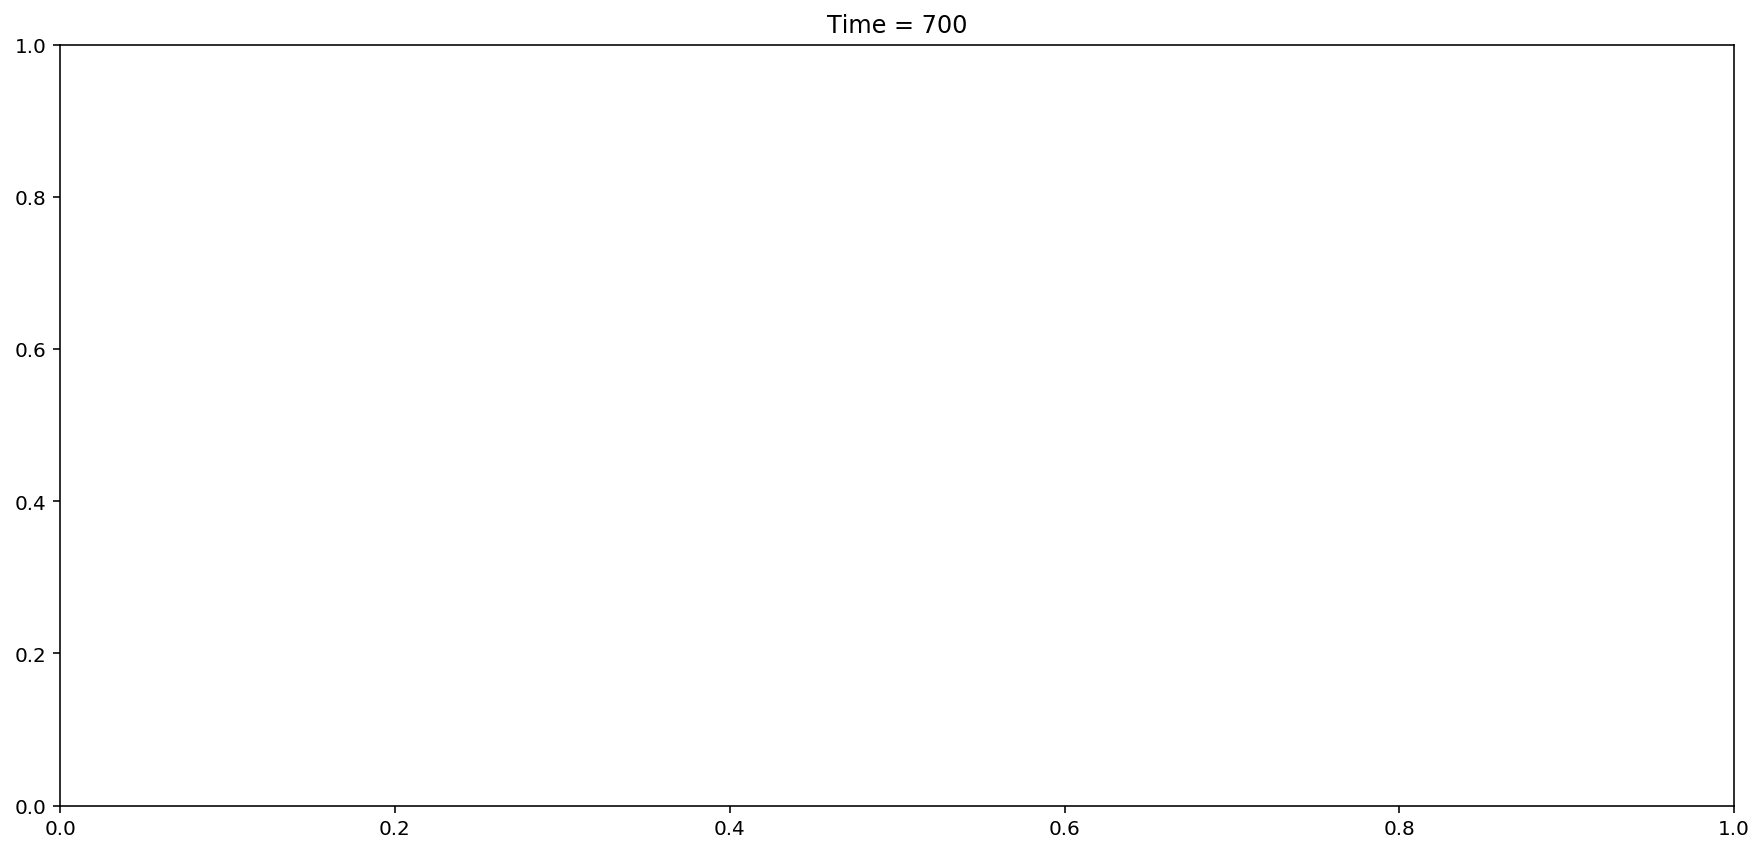

In [21]:
nrow=1
for tstep in tqdm(range(2, np.shape(data_arr)[0]-2)):
    ndata = interp(data_arr[tstep,:,:], ref[tstep,:,:])
    ndata = np.ma.masked_array(ndata, mask = mask)

    ref_field = np.ma.masked_array(ref[tstep,:,:], mask = mask)
    
    mse_data_ref.append(mse(ndata, ref_field))
    mse_mean_ref.append(mse(mean2d, ref_field))
    
    mean_data.append(np.nanmean(ndata))
    mean_ref.append(np.nanmean(ref_field))
    if tstep%100==0:
        plt.subplot(nrow, 1, nrow)
        plot(ndata, ref_field)
        nrow+=1

mean_ref=np.array(mean_ref)
mean_ref[mean_ref==0] = np.nan

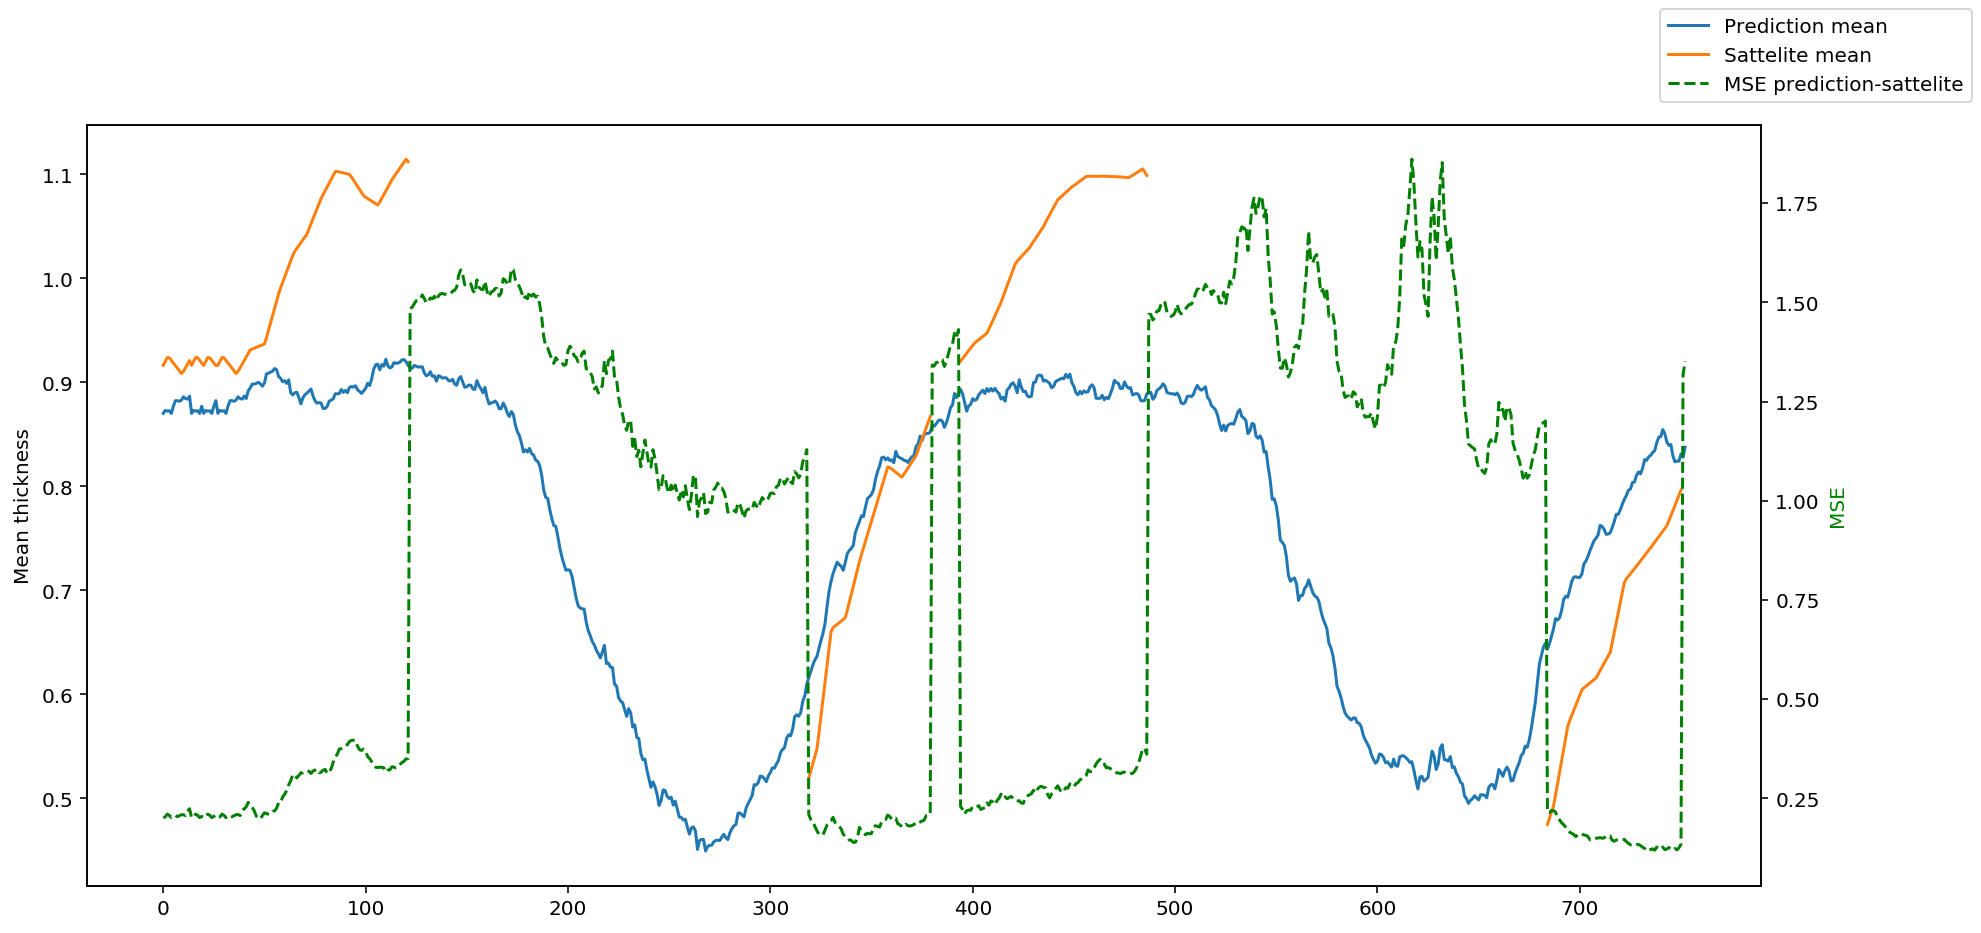

In [24]:
mean_ref=np.array(mean_ref)
mean_ref[mean_ref==0] = np.nan

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(mean_data, label = 'Prediction mean')
ax1.plot(mean_ref, label = 'Sattelite mean')
ax1.set_ylabel('Mean thickness')

ax2.plot(mse_data_ref, label = 'MSE prediction-sattelite', linestyle='dashed', color='green')
ax2.set_ylabel('MSE', color='green')

fig.legend()